## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [3]:
path = Path('/opt/SegNet-Tutorial/CamVid')

In [4]:
path.ls()

[PosixPath('/opt/SegNet-Tutorial/CamVid/train'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/val'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/models'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/test'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/trainannot')]

## Data

In [5]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/opt/SegNet-Tutorial/CamVid/val/0016E5_08059.png'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/val/0016E5_08097.png'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/val/0016E5_08019.png')]

In [6]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/opt/SegNet-Tutorial/CamVid/valannot/0016E5_08059.png'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/valannot/0016E5_08097.png'),
 PosixPath('/opt/SegNet-Tutorial/CamVid/valannot/0016E5_08019.png')]

Image (3, 360, 480)


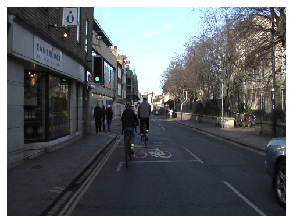

In [7]:
img_f = fnames[0]
img = open_image(img_f)
print(img)
img.show(figsize=(5,5))

In [8]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

/opt/SegNet-Tutorial/CamVid/valannot/0016E5_08059.png
Image (3, 360, 480)


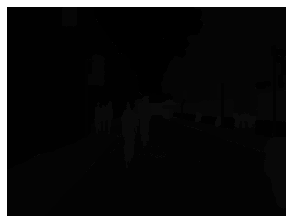

In [9]:
mask_img_path = (Path(str(img_f.parent) + 'annot')/img_f.name)
print(mask_img_path)
mask_img = open_image(mask_img_path)
print(mask_img)
mask_img.show(figsize=(5,5))

In [10]:
type(get_y_fn(img_f))

pathlib.PosixPath

In [11]:
img_f

PosixPath('/opt/SegNet-Tutorial/CamVid/val/0016E5_08059.png')

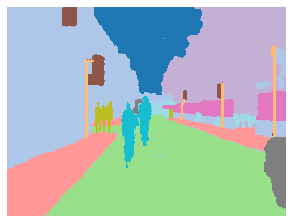

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

## Datasets

In [14]:
bs,size = 8,src_size//2

In [15]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
src

LabelLists;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /opt/SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /opt/SegNet-Tutorial/CamVid;

Test: None

In [17]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

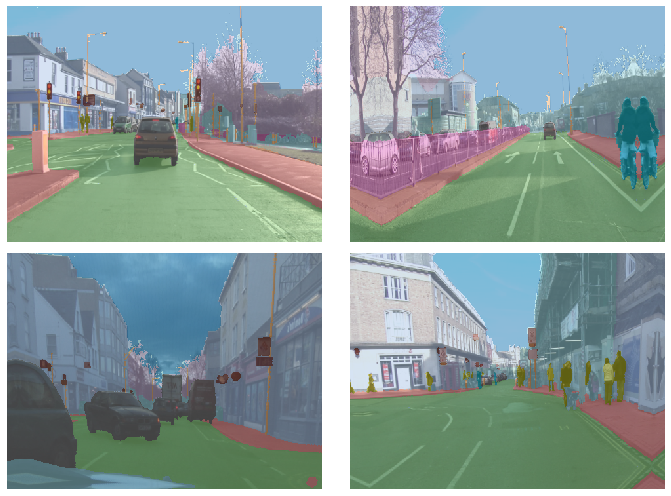

In [18]:
data.show_batch(2, figsize=(10,7))

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def accuracy_simple(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def dice_coefficient(input, target):
    target = target.squeeze(1)
    argmax = input.argmax(dim=1)
    x_in_y = (argmax==target).float().sum()
    return (2 * x_in_y) / (argmax.nelement() + target.nelement())

In [20]:
metrics=accuracy_simple
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

### Step for step training

In [21]:
x, y = data.one_batch()

In [26]:
x.shape, y.shape

(torch.Size([8, 3, 360, 480]), torch.Size([8, 1, 360, 480]))

In [36]:
x = x.cuda()
y = y.cuda()

In [28]:
y_hat = learn.model(x)

In [30]:
x.shape, y_hat.shape

(torch.Size([8, 3, 360, 480]), torch.Size([8, 12, 360, 480]))

In [40]:
loss = learn.loss_func(y_hat, y)

In [42]:
loss.backward()

In [43]:
lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 524.00 MiB (GPU 0; 7.79 GiB total capacity; 5.68 GiB already allocated; 407.00 MiB free; 750.77 MiB cached)

In [ ]:
lr=2e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

In [ ]:
learn=None
gc.collect()

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=8

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/1000,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [ ]:
# start: 480x360

In [ ]:
print(learn.summary())